# Homework 2 - InfluxDB
Advanced Information Systems and Big Data - A.Y. 2025-2026

Dataset: Crime Data from 2020 to Present (LAPD)

### Environment

In [1]:
# INSTALL
!pip install influxdb-client -q

# IMPORTS
import os
import subprocess
import time
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
import json
import warnings
from influxdb_client import InfluxDBClient, Point, WritePrecision, WriteOptions
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 746.3/746.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.6/218.6 kB 6.9 MB/s eta 0:00:00


### InfluxDB

In [2]:
# InfluxDB
!wget -q https://download.influxdata.com/influxdb/releases/influxdb2-2.7.4_linux_amd64.tar.gz
!tar xzf influxdb2-2.7.4_linux_amd64.tar.gz
!cp influxdb2-2.7.4/usr/bin/influxd /usr/local/bin/
!wget -q https://dl.influxdata.com/influxdb/releases/influxdb2-client-2.7.5-linux-amd64.tar.gz
!tar xzf influxdb2-client-2.7.5-linux-amd64.tar.gz
!cp influx /usr/local/bin/

# Start SERVER (Porta default: 8086)
!influxd >/dev/null 2>&1 &
!sleep 5
!influx setup \
  --username admin \
  --password adminpassword \
  --org lapd \
  --bucket crimes \
  --retention 0 \
  --force

# Start CLIENT
token_output = !influx auth list --json
TOKEN = json.loads(''.join(token_output))[0]['token']
URL = "http://localhost:8086"
ORG = "lapd"
client = InfluxDBClient(url=URL, token=TOKEN, org=ORG, timeout=500000)
# timeout is the maximum time to attend an answer

# api useful to read/query data
query_api = client.query_api()

# api useful to write points
write_api = client.write_api(
    write_options=WriteOptions(batch_size=5000, flush_interval=1000)
)

User	Organization	Bucket
admin	lapd		crimes


In [3]:
# DOWNLOAD DATASET - Crime Data LAPD
# Dataset: crimini registrati a Los Angeles dal 2020 al 2025
# Fonte: Los Angeles Open Data Portal (data.lacity.org)

df = pd.read_csv("https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD")
print(f"Record: {len(df)}")

Record: 1004991


## Parte 1: Caricamento dei Dati

In [4]:
# Il PREPROCESSING è essenziale per la qualità delle analisi Big Data

# 1. PARSING DATE: stringa -> datetime
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'],
                                format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
# errors='coerce': valori non parsabili diventano NaT (Not a Time)


# 2. RIMOZIONE VALORI NULLI O ANOMALI
df = df[
    (df['LAT'] != 0) & (df['LON'] != 0) &
    (df['DATE OCC'].notna()) &
    (df['DATE OCC'] <= '2025-11-30') &
    (df['DATE OCC'] >= '2020-01-01') &
    (df['Crm Cd'].notna()) # record senza codice crimine
].copy()
print(f"Record validi: {len(df)}")


# 3. FEATURE ENGINEERING
df['part'] = np.where(df['Part 1-2'] == 1, 'part1', 'part2')
#   - Part 1: crimini GRAVI (omicidio, rapina, furto con scasso, etc.)
#   - Part 2: crimini MENO GRAVI (vandalismo, frode, etc.)
#
df['has_weapon'] = np.where(df['Weapon Used Cd'].notna(), 1, 0)
#   - Analisi uso di arma
#
df['hour'] = (df['TIME OCC'] // 100).astype(int)
# formato HHMM, es. 1430 -> 14.30 -> 14

df['time_slot'] = np.where((df['hour'] < 8) | (df['hour'] >= 20), 'night', 'day')
#   - "night": 20:00-08:00 (ore notturne, potenzialmente più pericolose)
#   - "day": 08:00-20:00
#
df['year'] = df['DATE OCC'].dt.year
#
month = df['DATE OCC'].dt.month
df['season'] = np.select(
    [month.isin([12,1,2]), month.isin([3,4,5]), month.isin([6,7,8])],
    ['winter', 'spring', 'summer'],
    default='autumn'
)
#
df['district'] = df['Rpt Dist No'].fillna(0).astype(int).astype(str) #per evitare errori di parsing
df['area_id'] = df['AREA'].fillna(0).astype(int).astype(str)
df['area_name'] = df['AREA NAME'].fillna('unknown').str.replace(' ', '\\ ', regex=False)
df['vict_age'] = df['Vict Age'].fillna(0).clip(lower=0).astype(int)

Record validi: 1002751


In [5]:
# DATA MODEL INFLUXDB

# popola le righe del db con misure
def crea_point_crime(row, idx, MEASUREMENT = "crime"):
    punto = (
        Point(MEASUREMENT)  # Measurement name

        # ========== TAGS scelti ==========
        # Scelta di features CATEGORICHE con BASSA CARDINALITà per filtrare rapidamente
        .tag("district", str(row['district']))
        .tag("area_id", str(row['area_id']))
        .tag("area_name", str(row['AREA NAME']).replace(' ', '_'))
        .tag("part", row['part'])                     # Violento o no
        .tag("has_weapon", str(row['has_weapon']))    # Arma o no
        .tag("time_slot", row['time_slot'])           # "day" o "night"
        .tag("season", row['season'])
        .tag("year", str(row['year']))

        # ========== FIELDS scelti ==========
        # Scelta di features NUMERICHE o TESTUALI con ALTA CARDINALITà
        .field("crm_cd", int(row['Crm Cd']))
        .field("vict_age", int(row['vict_age']))
        .field("lat", float(row['LAT']))
        .field("lon", float(row['LON']))
        .field("count", 1)  # ogni crimine conta 1

        # ========== TIMESTAMP ==========
        # Indice temporale primario (serve aggiungere una piccola quantità
        # a ognuno per renderli unici!)
        .time(row['DATE OCC'] + pd.Timedelta(nanoseconds=idx), WritePrecision.NS)
    )
    return punto

In [6]:
# BATCH DATA LOADING
BUCKET = "crimes"
batch_size = 10000

# Cchiamata API tramite "with" x garanzia chiusura corretta
with client.write_api(write_options=WriteOptions(batch_size=5000, flush_interval=1000)) as write_api:
# this batch size refers to how many points are sent per HTTP request
    for i in range(0, len(df), batch_size):
        # this batch size refers to rows you process in memory at once
        batch = df.iloc[i:i+batch_size]  # Slice del DataFrame
        points = [crea_point_crime(row, i + j) for j, (_, row) in enumerate(batch.iterrows())]
        write_api.write(bucket=BUCKET, org=ORG, record=points)

### Alert

In [7]:
# SISTEMA DI ALERTING

# Calcolo statistiche giornaliere per definire la baseline
daily_stats = df.groupby(df['DATE OCC'].dt.date).agg({
    'DR_NO': 'count',                           # Totale crimini/giorno
    'part': lambda x: (x == 'part1').sum(),     # Crimini violenti/giorno
    'has_weapon': 'mean'                         # % con arma/giorno
}).rename(columns={'DR_NO': 'total', 'part': 'violent', 'has_weapon': 'weapon_pct'})

# Calcolo soglie come percentuale del massimo storico
SOGLIE = {
    'daily_warning': int(daily_stats['total'].max() * 0.05),     # 5% del max
    'daily_alarm': int(daily_stats['total'].max() * 0.10),       # 10% del max

    'violent_warning': int(daily_stats['violent'].max() * 0.05),  # 5% del max
    'violent_alarm': int(daily_stats['violent'].max() * 0.10),    # 10% del max

    'weapon_warning': daily_stats['weapon_pct'].max() * 0.05,  # 5% del max
    'weapon_alarm': daily_stats['weapon_pct'].max() * 0.10     # 10% del max
}

print("Soglie configurate:")
for k, v in SOGLIE.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

Soglie configurate:
  daily_alarm: 116
  violent_alarm: 66
  weapon_alarm: 0.1000


In [8]:
# Genera alert per giorni che superano le soglie

all_alerts = [] # [[data, DailyCrimes/Viol/Weap, warn/alarm, val]]

for data, row in daily_stats.iterrows():
    if row['total'] >= SOGLIE['daily_alarm']:
        all_alerts.append((data, 'daily', 'alarm', row['total']))
    elif row['total'] >= SOGLIE['daily_warning']:
        all_alerts.append((data, 'daily', 'warning', row['total']))

    if row['violent'] >= SOGLIE['violent_alarm']:
        all_alerts.append((data, 'violent', 'alarm', row['violent']))
    elif row['violent'] >= SOGLIE['violent_warning']:
        all_alerts.append((data, 'violent', 'warning', row['violent']))

    if row['weapon_pct'] >= SOGLIE['weapon_alarm']:
        all_alerts.append((data, 'weapon_pct', 'alarm', row['weapon_pct']))
    elif row['weapon_pct'] >= SOGLIE['weapon_warning']:
        all_alerts.append((data, 'weapon_pct', 'warning', row['weapon_pct']))

print(f"Alert generati: {len(all_alerts)} (Warning: {len([a for a in all_alerts if a[2]=='warning'])}, Alarm: {len([a for a in all_alerts if a[2]=='alarm'])})")

Alert generati: 5340 (Warning: 84, Alarm: 5256)


In [9]:
def crea_point_alert(row, MEASUREMENT = "alert"):
    punto = (
        Point(MEASUREMENT)  # Measurement name

        # ========== TAGS scelti ==========
        # Scelta di features
        .tag("type", row[1])        # Tipo di alert
        .tag("level", row[2])       # Gravità

        # ========== FIELDS scelti ==========
        .field("value", float(row[3]))

        # ========== TIMESTAMP ==========
        .time(pd.Timestamp(row[0]))               # Data
    )
    return punto

In [10]:
# PERSISTENZA ALERT SU INFLUXDB
# Salvo gli alert come MEASUREMENT SEPARATO ("alert" vs "crime")
# - Query indipendenti e mirate(non mischio crimini e alert)
# - Retention policy diverse (ex. alert per sempre nel db)

# Chiamata API tramite "with" x garanzia chiusura corretta
with client.write_api(write_options=WriteOptions(batch_size=1000, flush_interval=1000)) as write_api_alert:
    points = [crea_point_alert(a) for a in all_alerts]
    write_api_alert.write(bucket=BUCKET, org=ORG, record=points)

### Simulazione del Conteggio

In [11]:
# QUERY FLUX - Conteggio per Categoria (Part 1 vs Part 2)

print("Conteggi per part: (1=violent)")
result_part = query_api.query('''
from(bucket: "crimes")
  |> range(start: 2020-01-01T00:00:00Z)
  |> filter(fn: (r) => r._measurement == "crime" and r._field == "count")
  |> group(columns: ["part"])
  |> count()
''')
# Seleziona tutti i dati (dal 2020), "crime" e una colonna per riga(field=count)
#  Raggruppa i dati per il tag "part"
#  Crea gruppi separati per part1 e part2
#  Conta le dimensioni e metti in "_value"


for table in result_part: # itera per gruppi restituiti
    for r in table.records: # itera sui record
        print(f" {r.values.get('part')}: {r.get_value()}") # r Flux Object

Conteggi per part: (1=violent)
 part1: 601026
 part2: 400192


In [12]:
# QUERY FLUX - Conteggio per Presenza Arma

print("Conteggi per arma:")
result_weapon = query_api.query('''
from(bucket: "crimes")
  |> range(start: 2020-01-01T00:00:00Z)
  |> filter(fn: (r) => r._measurement == "crime" and r._field == "count")
  |> group(columns: ["has_weapon"])
  |> count()
''')
# Seleziona tutti i dati (dal 2020), "crime" e una colonna per riga(field=count)
#  Raggruppa i dati per il tag "has_weapon"
#  Crea gruppi separati per 0 e 1
#  Conta le dimensioni e metti in "_value"


for table in result_weapon: # itera per gruppi restituiti
    for r in table.records: # itera sui record
        print(f"  arma_{r.values.get('has_weapon')}: {r.get_value()}") # r Flux Object

Conteggi per arma:
  arma_0: 675331
  arma_1: 325887


In [13]:
# QUERY FLUX - Top 10 Aree per Numero di Crimini

print("Top 10 aree per crimini:")
result = query_api.query('''
from(bucket: "crimes")
  |> range(start: 2020-01-01T00:00:00Z)
  |> filter(fn: (r) => r._measurement == "crime" and r._field == "count")
  |> group(columns: ["area_name"])
  |> count()
  |> sort(columns: ["_value"], desc: true)
  |> limit(n: 10)
''')
# Seleziona tutti i dati (dal 2020), "crime" e una colonna per riga(field=count)
#  Raggruppa i dati per "area_name"
#  Crea gruppi separati per le diverse aree
#  Conta le dimensioni e metti in "_value"
#  Ordina e prende solo i primi 10


for table in result: # itera per gruppi restituiti
    for r in table.records: # itera sui record
        print(f"  {r.values.get('area_name')}: {r.get_value()}") # r Flux Object

Top 10 aree per crimini:
  77th_Street: 61529
  Central: 69323
  Devonshire: 41607
  Foothill: 33012
  Harbor: 41255
  Hollenbeck: 36952
  Hollywood: 52042
  Mission: 40170
  N_Hollywood: 50940
  Newton: 49000
  Northeast: 42867
  Olympic: 49878
  Pacific: 59259
  Rampart: 46628
  Southeast: 49714
  Southwest: 57289
  Topanga: 41276
  Van_Nuys: 42762
  West_LA: 45617
  West_Valley: 42071
  Wilshire: 48027


## Part 2: Interrogazioni Analitiche

### Query 1: Media giornaliera per area e stagione

In [7]:
# QUERY 1: Media Giornaliera Crimini per Area e Stagione

t0 = time.time()

result = query_api.query('''
from(bucket: "crimes")
  |> range(start: 2020-01-01T00:00:00Z)
  |> filter(fn: (r) => r._measurement == "crime" and r._field == "count")
  |> group(columns: ["area_name", "season"])
  |> aggregateWindow(every: 1d, fn: sum, createEmpty: false)
  |> mean()
''')
# Seleziona tutti i dati (dal 2020), "crime" e una colonna per riga(field=count)
# Raggruppa per (area, stagione)
# Per ogni gruppo, somma per giorno i valori di "count" (1 per tutte le righe)
# Per ogni gruppo, calcola media delle somme giornaliere (in _value)

t_global = time.time() - t0

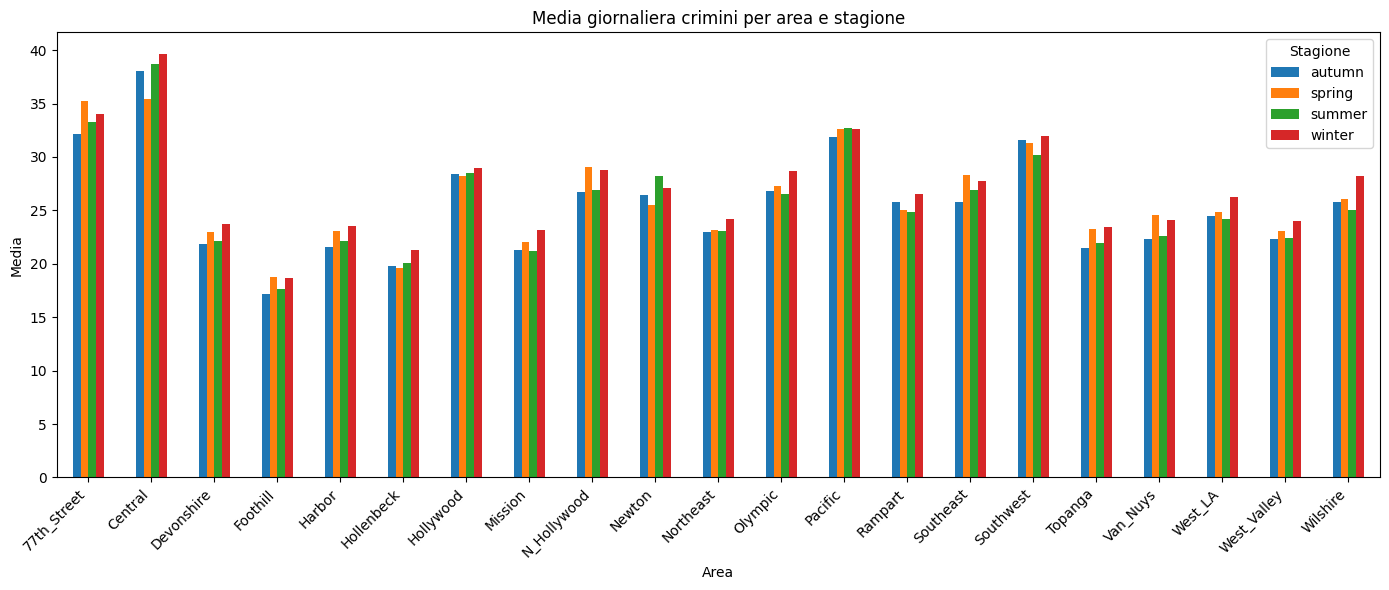


Picchi stagionali:
  77th_Street: spring
  Central: winter
  Devonshire: winter
  Foothill: spring
  Harbor: winter
  Hollenbeck: winter
  Hollywood: winter
  Mission: winter
  N_Hollywood: spring
  Newton: summer
  Northeast: winter
  Olympic: winter
  Pacific: summer
  Rampart: winter
  Southeast: spring
  Southwest: winter
  Topanga: winter
  Van_Nuys: spring
  West_LA: winter
  West_Valley: winter
  Wilshire: winter


In [8]:
data = []
for table in result:
    for r in table.records:
        data.append({
            'area': r.values.get('area_name'),
            'season': r.values.get('season'),
            'avg': r.get_value()
        })
# Pivot per visualizzazione (righe=aree, colonne=stagioni)
df_q1 = pd.DataFrame(data)
pivot = df_q1.pivot(index='area', columns='season', values='avg').fillna(0)
pivot.plot(kind='bar', figsize=(14, 6))
plt.title('Media giornaliera crimini per area e stagione')
plt.xlabel('Area')
plt.ylabel('Media')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Stagione')
plt.tight_layout()
plt.show()

print("\nPicchi stagionali:")
for area in pivot.index:
    peak = pivot.loc[area].idxmax()  # Stagione con media più alta
    print(f"  {area}: {peak}")

In [9]:
# BENCHMARK: Query Globale vs Query Filtrata

print(f"Tempo query globale: {t_global:.2f}s")

print("\nTempo query per stagione")
# Eseguiamo la stessa query 4 volte, filtrando per stagione
for season in ['winter', 'spring', 'summer', 'autumn']:
    t0 = time.time()
    result = query_api.query(f'''
    from(bucket: "crimes")
      |> range(start: 2020-01-01T00:00:00Z)
      |> filter(fn: (r) => r._measurement == "crime" and r._field == "count")
      |> filter(fn: (r) => r.season == "{season}")
      |> group(columns: ["area_name"])
      |> aggregateWindow(every: 1d, fn: sum, createEmpty: false)
      |> mean()
    ''')
    # Poiché season è un TAG (indicizzato), InfluxDB può
    # usare l'indice per trovare rapidamente i dati di quella stagione
    elapsed = time.time() - t0
    print(f"{season}: {elapsed:.2f}s")

Tempo query globale: 245.48s

Tempo query per stagione
winter: 64.20s
spring: 68.75s
summer: 73.55s
autumn: 84.25s


### Query 2: Distribuzione part 1-2 per fascia oraria (mese: Luglio 2023)

In [10]:
# QUERY 2: Distribuzione per Categoria e Fascia Oraria (Luglio 2023)

t0 = time.time()

result = query_api.query('''
from(bucket: "crimes")
  |> range(start: 2023-07-01T00:00:00Z, stop: 2023-08-01T00:00:00Z)
  |> filter(fn: (r) => r._measurement == "crime" and r._field == "count")
  |> group(columns: ["part", "time_slot"])
  |> count()
''')
# Seleziona crimini di Luglio 2023, "crime" e field=count
# Raggruppa per (part, time_slot)
# Per ogni gruppo, calcola somme di count (in _value)

t_global = time.time() - t0

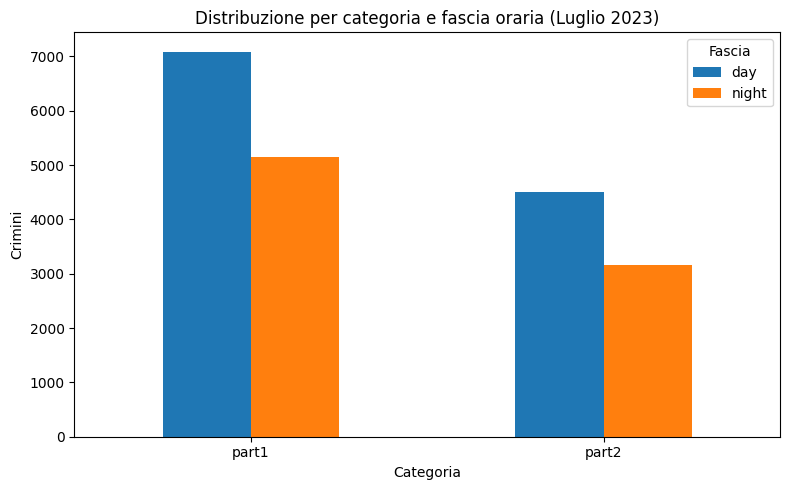


Analisi:
  part1: giorno 57.9%, notte 42.1%
  part2: giorno 58.9%, notte 41.1%


In [11]:
data = []
for table in result:
    for r in table.records:
        data.append({
            'part': r.values.get('part'),
            'time_slot': r.values.get('time_slot'),
            'count': r.get_value()
        })

df_q2 = pd.DataFrame(data)
pivot2 = df_q2.pivot(index='part', columns='time_slot', values='count').fillna(0)
pivot2.plot(kind='bar', figsize=(8, 5))
plt.title('Distribuzione per categoria e fascia oraria (Luglio 2023)')
plt.xlabel('Categoria')
plt.ylabel('Crimini')
plt.xticks(rotation=0)
plt.legend(title='Fascia')
plt.tight_layout()
plt.show()

# Calcolo percentuali giorno/notte per ogni categoria
print("\nAnalisi:")
for p in pivot2.index:
    tot = pivot2.loc[p].sum()
    print(f"  {p}: giorno {pivot2.loc[p,'day']/tot*100:.1f}%, notte {pivot2.loc[p,'night']/tot*100:.1f}%")

In [12]:
# BENCHMARK: Query Globale vs Query Filtrata
print(f"Tempo query globale: {t_global:.2f}s")

print("\nTempo query per stagione")
# Eseguiamo la stessa query 4 volte, filtrando per stagione
for season in ['winter', 'spring', 'summer', 'autumn']:
    t0 = time.time()
    result = query_api.query(f'''
    from(bucket: "crimes")
      |> range(start: 2023-07-01T00:00:00Z, stop: 2023-08-01T00:00:00Z)
      |> filter(fn: (r) => r._measurement == "crime" and r._field == "count")
      |> filter(fn: (r) => r.season == "{season}")
      |> group(columns: ["part", "time_slot"])
      |> count()
    ''')
    # Poiché season è un TAG (indicizzato), InfluxDB può
    # usare l'indice per trovare rapidamente i dati di quella stagione
    print(f"{season}: {time.time()-t0:.2f}s")

Tempo query globale: 0.21s

Tempo query per stagione
winter: 0.01s
spring: 0.01s
summer: 0.24s
autumn: 0.01s


### Query 3: Giornata con piu crimini violenti per area

In [13]:
# QUERY 3: Giornata con Più Crimini Violenti per Area

t0 = time.time()

result = query_api.query('''
from(bucket: "crimes")
  |> range(start: 2020-01-01T00:00:00Z)
  |> filter(fn: (r) => r._measurement == "crime" and r._field == "count")
  |> filter(fn: (r) => r.part == "part1")
  |> group(columns: ["area_name"])
  |> aggregateWindow(every: 1d, fn: sum, createEmpty: false)
  |> max()
''')
# Seleziona tutti i dati (dal 2020), "crime" e una colonna per riga(field=count)
# Filtra per tag = arma)part1)
# Raggruppa per "area_name"
# Per ogni area_name, somma per giorno i valori di "count" (1 per tutte le righe)
# Per ogni area_name, ritorna il max (in _value)

t_global = time.time() - t0

In [14]:
print("\nTabella:")
print(f"{'Area':<20} {'Data':<12} {'Mese':<12} {'Conteggio'}")
print("-" * 55)

mesi = []
for table in result:
    for r in table.records:
        area = r.values.get('area_name')
        data = r.get_time().strftime('%Y-%m-%d') # timestamp del FluxObject
        mese = r.get_time().strftime('%B')# timestamp del FluxObject
        mesi.append(mese)
        print(f"{area:<20} {data:<12} {mese:<12} {r.get_value()}")

# Analisi distribuzione mesi dei picchi
print("\nConcentrazione per mese:")
for m, c in pd.Series(mesi).value_counts().items():
    print(f"  {m}: {c}")


Tabella:
Area                 Data         Mese         Conteggio
-------------------------------------------------------
77th_Street          2023-11-12   November     42
Central              2020-05-30   May          93
Devonshire           2020-07-21   July         32
Foothill             2022-02-02   February     31
Harbor               2021-06-02   June         34
Hollenbeck           2022-07-28   July         27
Hollywood            2020-06-02   June         43
Mission              2021-03-19   March        35
N_Hollywood          2022-10-27   October      40
Newton               2021-07-26   July         42
Northeast            2023-11-12   November     41
Olympic              2023-11-25   November     43
Pacific              2022-10-12   October      45
Rampart              2023-09-02   September    38
Southeast            2020-07-04   July         37
Southwest            2023-08-07   August       88
Topanga              2021-09-24   September    31
Van_Nuys             2020-0

In [15]:
# BENCHMARK: Query Globale vs Query Filtrata
print(f"Tempo query globale: {t_global:.2f}s")

print("\nTempo query per stagione")
# Eseguiamo la stessa query 4 volte, filtrando per stagione
for season in ['winter', 'spring', 'summer', 'autumn']:
    t0 = time.time()
    result = query_api.query(f'''
    from(bucket: "crimes")
      |> range(start: 2020-01-01T00:00:00Z)
      |> filter(fn: (r) => r._measurement == "crime" and r._field == "count")
      |> filter(fn: (r) => r.part == "part1" and r.season == "{season}")
      |> group(columns: ["area_name"])
      |> aggregateWindow(every: 1d, fn: sum, createEmpty: false)
      |> max()
    ''')
    # Poiché season è un TAG (indicizzato), InfluxDB può
    # usare l'indice per trovare rapidamente i dati di quella stagione
    print(f"{season}: {time.time()-t0:.2f}s")

Tempo query globale: 267.85s

Tempo query per stagione
winter: 66.33s
spring: 64.06s
summer: 64.26s
autumn: 60.99s


### Query 4: Età media vittime

In [16]:
# QUERY 4: Età Media Vittime per Year e Categoria di part

t0 = time.time()

result = query_api.query("""
import "date"
from(bucket: "crimes")
  |> range(start: 2020-01-01T00:00:00Z)
  |> filter(fn: (r) =>
      r._measurement == "crime" and
      r._field == "vict_age" and
      r._value > 0
  )
  |> group(columns: ["year", "part"])
  |> mean()
""")
# Seleziona crimini dal 2020, "crime" e field=vict_age (con _value>0 =miss val --> non c'è la certezza del fieldCount=1!)
# Filtra per tag = arma)part1)
# Raggruppa per "year" e "part"
# Per ogni gruppo, ritorna la media valori (in _value)

t_global = time.time() - t0


Eta media:
part  part1  part2
year              
2020   39.8   39.5
2021   39.6   39.6
2022   39.5   39.3
2023   39.7   39.5
2024   38.6   39.5
2025   24.1   22.0


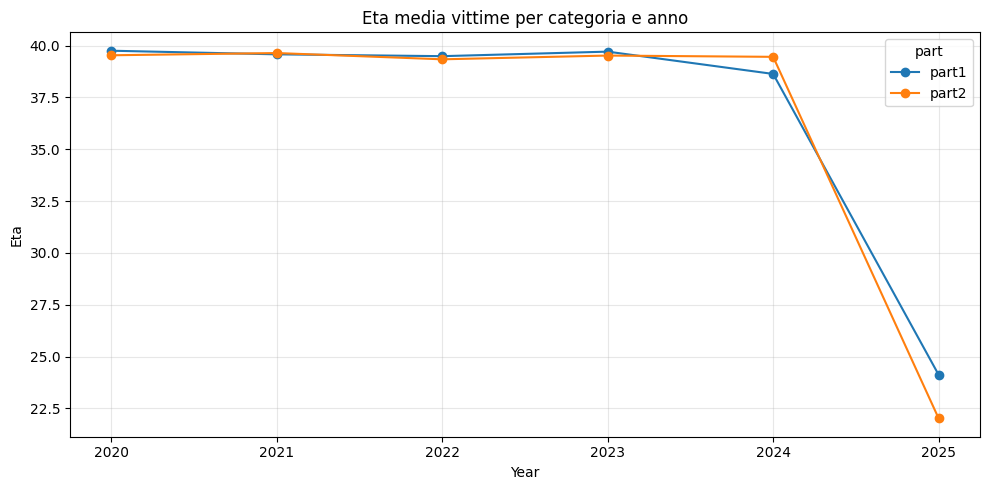

In [17]:
data = [{'year': int(r.values.get('year')), 'part': r.values.get('part'), 'avg': r.get_value()}
        for table in result for r in table.records]

pivot_eta = pd.DataFrame(data).pivot(index='year', columns='part', values='avg')
print("\nEta media:")
print(pivot_eta.round(1))
pivot_eta.plot(kind='line', marker='o', figsize=(10, 5))
plt.title('Eta media vittime per categoria e anno')
plt.xlabel('Year')
plt.ylabel('Eta')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# BENCHMARK: Query Globale vs Query Filtrata
print(f"Tempo query globale: {t_global:.2f}s")

print("\nTempo query per stagione")
# Eseguiamo la stessa query 4 volte, filtrando per stagione
for season in ['winter', 'spring', 'summer', 'autumn']:
    t0 = time.time()
    result = query_api.query(f'''
import "date"
    from(bucket: "crimes")
      |> range(start: 2020-01-01T00:00:00Z)
      |> filter(fn: (r) => r._measurement == "crime" and r._field == "vict_age")
      |> filter(fn: (r) => r.vict_age > 0 and r.season == "{season}")
      |> group(columns: ["part", "year"])
      |> mean()
    ''')
    # Poiché season è un TAG (indicizzato), InfluxDB può
    # usare l'indice per trovare rapidamente i dati di quella stagione
    print(f"{season}: {time.time()-t0:.2f}s")

Tempo query globale: 368.32s

Tempo query per stagione
winter: 78.09s
spring: 76.85s
summer: 76.39s
autumn: 70.39s


## Part 3: Clustering Incrementale

### Clustering Incrementale

Clustering con MiniBatchKMeans e `partial_fit()` per aggiornamento incrementale.

*   Variabili: n_crimes, pct_weapon, pct_night, pct_violent.

*   Aggregazione: area, stagione, anno.

In [32]:
# AGGREGAZIONE DATI PER CLUSTERING
features = ['n_crimes', 'pct_weapon', 'pct_violent', 'pct_night']
aggregates = ['area', 'season', 'year']

agg = df.groupby(['AREA NAME', 'season', 'year']).agg({
    'DR_NO': 'count',                              # Num crimini
    'has_weapon': 'mean',                          # % uso arma  (essendo binario è %)
    'part': lambda x: (x == 'part1').mean(),       # % violenti  (essendo binario è %)
    'time_slot': lambda x: (x == 'night').mean()   # % notte     (essendo binario è %)
}).reset_index()
agg.columns = aggregates + features

print(f"Record aggregati: {len(agg)}")

Record aggregati: 449


In [33]:
# CLUSTERING INCREMENTALE CON MiniBatchKMeans

def clustering_incrementale(df, features, n_clusters=2):
    df = df.copy()

    # NORMALIZZAZIONE
    scaler = StandardScaler()
    # StandardScaler: trasforma ogni feature in media=0, std=1
    X = scaler.fit_transform(df[features])

    # MiniBatchKMeans
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=50)

    # Clustering incrementale: --> TIME-WINDOW = 1 YEAR
    for year in sorted(df['year'].unique()):
        mask = df['year'] == year # per filtrare il dataframe
        kmeans.partial_fit(X[mask])
        # Assegna cluster ai punti dell'anno corrente
        df.loc[mask, 'cluster'] = kmeans.predict(X[mask])

        # Mostra distribuzione cluster per questo anno
        print(f"{year}: {np.bincount(df.loc[mask, 'cluster'].astype(int), minlength=n_clusters)}")

    return df

In [34]:
# Esecuzione clustering
agg = clustering_incrementale(agg, features)
agg.groupby(['year', 'cluster'])[features].mean().round(3)

2020: [58 26]
2021: [55 29]
2022: [51 33]
2023: [49 35]
2024: [79  5]
2025: [23  6]


n_crimes  pct_weapon  pct_violent  pct_night
year cluster                                              
2020 0.0      2205.879       0.314        0.581      0.387
     1.0      2735.192       0.458        0.578      0.412
2021 0.0      2291.364       0.299        0.588      0.394
     1.0      2841.621       0.437        0.590      0.414
2022 0.0      2481.118       0.283        0.574      0.397
     1.0      3294.576       0.390        0.571      0.422
2023 0.0      2446.224       0.292        0.594      0.384
     1.0      3213.600       0.395        0.605      0.416
2024 0.0      1464.810       0.134        0.717      0.390
     1.0      2369.400       0.417        0.600      0.417
2025 0.0         3.217       0.136        0.315      0.216
     1.0         3.833       0.903        0.000      0.115

In [35]:
# ANALYSIS EVOLUZIONE TEMPORALE DEI CLUSTER
# Confronto l'assegnazione ai cluster tra 2020 e 2024
# per identificare aree che hanno cambiato "profilo criminale"

# estrazione cluster per ogni area nel 2020 e 2024
c2020 = agg[agg['year'] == 2020].groupby('area')['cluster'].first()
c2024 = agg[agg['year'] == 2024].groupby('area')['cluster'].first()

comp = pd.DataFrame({'2020': c2020, '2024': c2024}).dropna()
changed = comp[comp['2020'] != comp['2024']] # aree dove il cluster è cambiato

print(f"Aree cambiate: {len(changed)} su {len(comp)}")
if len(changed) > 0:
    print("\nDettaglio:")
    for area, row in changed.iterrows():
        print(f"  {area}: {int(row['2020'])} -> {int(row['2024'])}")

Aree cambiate: 8 su 21

Dettaglio:
  77th Street: 1 -> 0
  Central: 1 -> 0
  Hollywood: 1 -> 0
  Newton: 1 -> 0
  Olympic: 1 -> 0
  Rampart: 1 -> 0
  Southeast: 1 -> 0
  Southwest: 1 -> 0


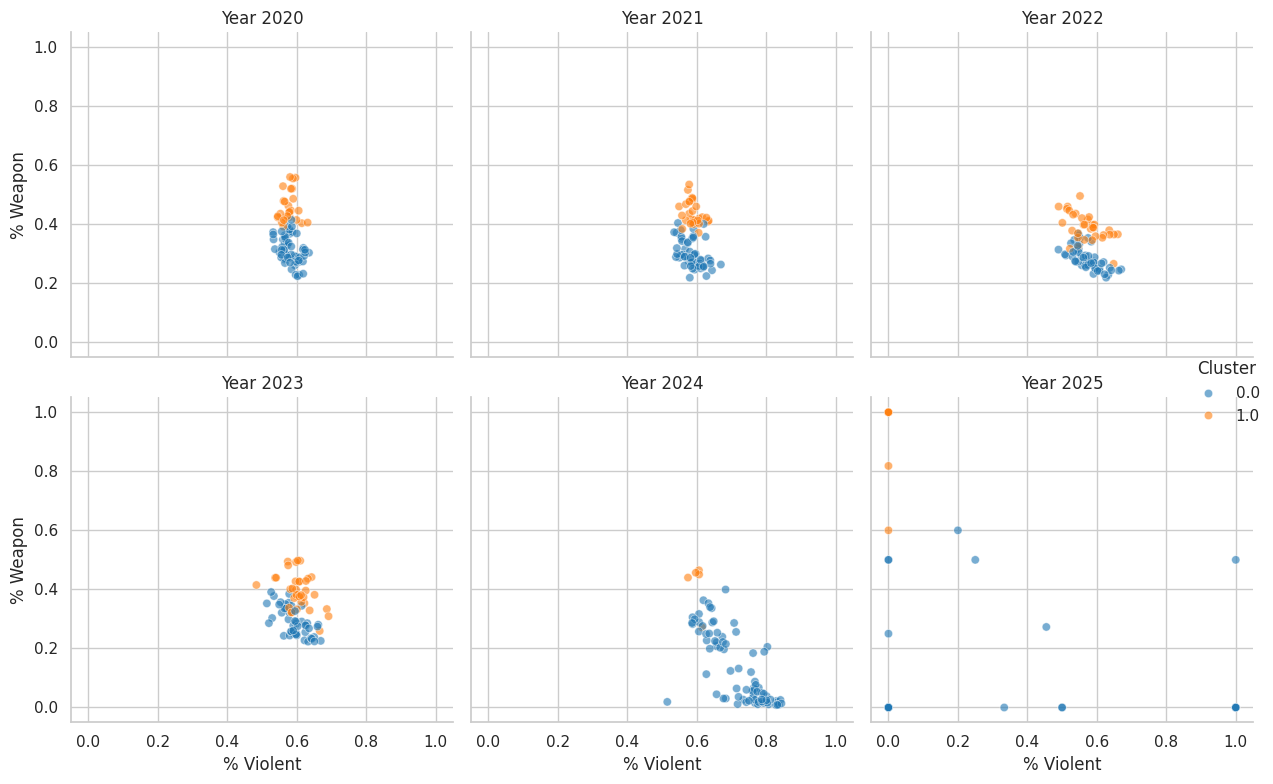


CLUSTER 0 — Low weapon usage, highly violent, daytime crime
CLUSTER 1 — High weapon usage, less violent, nighttime crime



In [36]:
# VISUALIZATION

agg['year'] = agg['year'].astype(str)

sns.set(style="whitegrid")
g = sns.FacetGrid(agg, col="year", col_wrap=3, height=4, sharex=True, sharey=True) #one chart per year
g.map_dataframe(sns.scatterplot, x='pct_violent', y='pct_weapon', hue='cluster', palette={0: "#1f77b4", 1: "#ff7f0e"}, alpha=0.6)
g.add_legend(title='Cluster')
g.set_axis_labels('% Violent', '% Weapon')
g.set_titles('Year {col_name}')
plt.tight_layout()
plt.show()

print(
    "\nCLUSTER 0 — Low weapon usage, highly violent, daytime crime\n"
    "CLUSTER 1 — High weapon usage, less violent, nighttime crime\n"
)